# Denoising with generative models

## Pytorch tests

### Creating a few tensors as tests

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import matplotlib.pyplot as plt

In [3]:
x = torch.rand(1, 1, 1024) # (batch_size, n_channels, dim)
y = torch.rand(1, 1, 1024)

In [4]:
x

tensor([[[0.4482, 0.8091, 0.5076,  ..., 0.2804, 0.7680, 0.2190]]])

In [5]:
y

tensor([[[0.5535, 0.6015, 0.7956,  ..., 0.2637, 0.0438, 0.8346]]])

In [6]:
z = torch.cat((x,y), 1)

In [7]:
z

tensor([[[0.4482, 0.8091, 0.5076,  ..., 0.2804, 0.7680, 0.2190],
         [0.5535, 0.6015, 0.7956,  ..., 0.2637, 0.0438, 0.8346]]])

In [8]:
w = torch.rand(1, 4, 1024)

In [9]:
w

tensor([[[0.5599, 0.9341, 0.7477,  ..., 0.7605, 0.0270, 0.2522],
         [0.3813, 0.3598, 0.5604,  ..., 0.5575, 0.1808, 0.4337],
         [0.7438, 0.5029, 0.5536,  ..., 0.1019, 0.6745, 0.5575],
         [0.7155, 0.0688, 0.4105,  ..., 0.4623, 0.4390, 0.6918]]])

### Subpixel operation

In [10]:
# from https://gist.github.com/davidaknowles/6e95a643adaf3960d1648a6b369e9d0b
def pixel_shuffle_1d(x, upscale_factor):
    batch_size, channels, steps = x.size()
    channels //= upscale_factor
    input_view = x.contiguous().view(batch_size, channels, upscale_factor, steps)
    shuffle_out = input_view.permute(0, 1, 3, 2).contiguous()
    return shuffle_out.view(batch_size, channels, steps * upscale_factor)

In [11]:
pixel_shuffle_1d(z, 2)

tensor([[[0.4482, 0.5535, 0.8091,  ..., 0.0438, 0.2190, 0.8346]]])

In [12]:
pixel_shuffle_1d(w, 2)

tensor([[[0.5599, 0.3813, 0.9341,  ..., 0.1808, 0.2522, 0.4337],
         [0.7438, 0.7155, 0.5029,  ..., 0.4390, 0.5575, 0.6918]]])

### Generate base sizes and count for each level

In [13]:
# this is what they implemented in their git project

def get_sizes_for_layers(B):
    n_channels = []
    size_filters = []
    #test = []
    for b in range(1, B+1):
        n_channels.append(min(2**(6 + b), 512)) # They wrote max in paper, but min in code
        size_filters.append(max(2**(7-b) + 1, 9)) # They wrote min in paper, but max in code
        #test.append(min(2**(7+(B-b+1)), 512))
    
    return n_channels, size_filters

In [14]:
B = 4
n_channels, size_filters = get_sizes_for_layers(B)

In [15]:
n_channels, size_filters #Checking values

([128, 256, 512, 512], [65, 33, 17, 9])

### Generate correct parameters for up and down

In [16]:
# The input channel count is equal to the the output channel count of the previous layer
# Input will be all the channel counts, shifted to the right with a 1 before
def args_down(n_channels, size_filters):
    return zip([1] + n_channels[:-1], n_channels, size_filters)

# Input filter count is the size of the bottlneck for the first up layer
# And then it will be the count of the previous up layer, which is equal to twice the count of the down layer
# (since we do some stacking with the skip connections)

# Output filter count  will be twice the count of the down layer 
# so that after the subpixel we get the same count as in the down layer
# and we can stack them together
def args_up(n_channels, size_filters):
    return zip([int(n_channels[-1]/2)] + n_channels[::-1][:-1], n_channels[::-1], size_filters[::-1])

In [17]:
list(args_down(n_channels, size_filters))

[(1, 128, 65), (128, 256, 33), (256, 512, 17), (512, 512, 9)]

In [18]:
list(args_up(n_channels, size_filters))

[(256, 512, 9), (512, 512, 17), (512, 256, 33), (256, 128, 65)]

#### And if we use the arguments, we get the same parameters as the manually defined ones

In [19]:
for n_ch_in, n_ch_out, size in args_down(n_channels, size_filters):
    print(n_ch_in, n_ch_out, size)
print(n_channels[-1], size_filters[-1])
            
for n_ch_in, n_ch_out, size in args_up(n_channels, size_filters):
    print(n_ch_in*2, n_ch_out*2, size)
                                            
print(n_channels[0]*2, 9)

1 128 65
128 256 33
256 512 17
512 512 9
512 9
512 1024 9
1024 1024 17
1024 512 33
512 256 65
256 9


## Neural Network architecture

In [20]:
class Subpixel(nn.Module):
    def __init__(self):
        super(Subpixel, self).__init__()
           
    def forward(self, x):
        y = pixel_shuffle_1d(x, 2)
        return y

In [21]:
class Concat(nn.Module):
    def __init__(self):
        super(Concat, self).__init__()
           
        
    def forward(self, x1, x2):
        y = torch.cat((x1, x2), 1) # concat on dim 1 (channel dimension)
        return y

In [22]:
class Add(nn.Module):
    def __init__(self):
        super(Add, self).__init__()
           
        
    def forward(self, x1, x2):
        y = torch.add(x1, x2)
        return y

In [23]:
class Downsampling(nn.Module):
    
    def __init__(self, in_ch, out_ch, size, verbose=0):
        super(Downsampling, self).__init__()
        self.verbose = verbose
        
        self.conv = nn.Sequential(
            # We need a padding mode = same to get the same behavior as the paper
            # But it doesn't seem to exist in pytorch
            nn.Conv1d(in_channels=in_ch, out_channels=out_ch, kernel_size=size, stride=2, padding_mode='zeros', padding=int((size-1)/2)), 
            nn.LeakyReLU(0.2)
        )
        
    def forward(self, x):
        if self.verbose: print("Before conv down : " + str(x.size()))
        y = self.conv(x)
        if self.verbose: print("After conv down : " + str(y.size()))
        return y

In [24]:
class Bottleneck(nn.Module):
    def __init__(self, ch, size, verbose=0):
        super(Bottleneck, self).__init__()
        self.verbose = verbose
        self.conv = nn.Sequential(
            # We need a padding mode = same to get the same behavior as the paper
            # But it doesn't seem to exist in pytorch
            nn.Conv1d(in_channels=ch, out_channels=ch, kernel_size=size, stride=2, padding_mode='zeros', padding = int((size-1)/2)), 
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2)
        )
        
    def forward(self, x):
        if self.verbose: print("Bottleneck before: " + str(x.size()))
        y = self.conv(x)
        if self.verbose: print("Bottleneck after: " + str(y.size()))
        return y

In [25]:
class Upsampling(nn.Module):
    def __init__(self, in_ch, out_ch, size, verbose=0):
        super(Upsampling, self).__init__()
        self.verbose = verbose
        self.conv = nn.Sequential(
            # We need a padding mode = same to get the same behavior as the paper
            # But it doesn't seem to exist in pytorch
            nn.Conv1d(in_channels=in_ch, out_channels=out_ch, kernel_size=size, stride=1, padding_mode='zeros', padding = int((size-1)/2)),
            nn.Dropout(p=0.5),
            nn.ReLU()
        )
        self.subpixel = Subpixel()
        self.concat = Concat()
        
    def forward(self, x1, x2):
        if self.verbose: print("Upsampling before: " + str(x1.size()))
        y = self.conv(x1)
        if self.verbose: print("Upsampling conv: " + str(y.size()))
        y = self.subpixel(y)
        if self.verbose: print("Upsampling subpixel: " + str(y.size()))
        y = self.concat(y, x2)
        if self.verbose: print("Upsampling concat: " + str(y.size()))
        return y

In [26]:
class LastConv(nn.Module):
    def __init__(self, in_ch, size, verbose=0):
        super(LastConv, self).__init__()
        self.verbose = verbose
        self.conv = nn.Conv1d(in_channels=in_ch, out_channels=2, kernel_size=9, stride=1, padding_mode='zeros', padding = int((size-1)/2))
        self.subpixel = Subpixel()
        self.add = Add()
           
        
    def forward(self, x1, x2):
        if self.verbose: print("Final before: " + str(x1.size()))
        y = self.conv(x1)
        if self.verbose: print("Final conv: " + str(y.size()))
        y = self.subpixel(y)
        if self.verbose: print("Final subpixel: " + str(y.size()))
        y = self.add(y, x2)
        if self.verbose: print("Final add: " + str(y.size()))
        return y

In [27]:
class Net(nn.Module):

    def __init__(self, depth, verbose=0):
        super(Net, self).__init__()
        self.verbose = verbose
        
        
        
        # Manual definition
        
        
        #B = 4
        #n_channels= [128, 256, 512, 512] # max(2^(6+b), 512) 
        #size_filters = [65, 33, 17, 9] # min(2^(7−b) + 1, 9)
        
        #self.down1 = Downsampling(1, 128, 63)
        #self.down2 = Downsampling(128, 256, 33)
        #self.down3 = Downsampling(256, 512, 17)
        #self.down4 = Downsampling(512, 512, 9)
        #self.bottleneck = Bottleneck(512, 9)
        #self.up1 = Upsampling(int((512/2)*2), 512*2, 9)
        #self.up2 = Upsampling(512*2, 512*2, 17)
        #self.up3 = Upsampling(512*2, 256*2, 33)
        #self.up4 = Upsampling(256*2, 128*2, 63)
        #self.last = LastConv(128*2, 9)

        
        # Automatic definition, seems to work :
        
        B = depth
        n_channels, size_filters = get_sizes_for_layers(B)
        
        # Downsampling
        self.down = []
        for n_ch_in, n_ch_out, size in args_down(n_channels, size_filters):
            self.down.append(Downsampling(n_ch_in, n_ch_out, size, verbose))
            
        # Bottlneck
        self.bottleneck = Bottleneck(n_channels[-1], size_filters[-1], verbose)
        
        # Upsampling
        self.up = []
        for n_ch_in, n_ch_out, size in args_up(n_channels, size_filters):
            self.up.append(Upsampling(n_ch_in*2, n_ch_out*2, size, verbose))
              
        # Final layer
        self.last = LastConv(n_channels[0]*2, 9, verbose)
        
        
        

    def forward(self, x):

        # Manual 
        
        #x1 = self.down1(x)
        #x2 = self.down2(x1)
        #x3 = self.down3(x2)
        #x4 = self.down4(x3)
        #b = self.bottleneck(x4)
        #y = self.up1(b, x4)
        #y = self.up2(y, x3)
        #y = self.up3(y, x2)
        #y = self.up4(y, x1)
        #y = self.last(y, x)
        
        # Automatic
        
        # Downsampling
        down_out = []
        xi = x
        for i in range(len(self.down)):
            xi = self.down[i](xi)
            down_out.append(xi)
            
        # Bottleneck
        b = self.bottleneck(xi)
        
        # Upsampling
        y = b
        for i in range(len(self.up)):
            y = self.up[i](y, down_out[-(i+1)])
            
        # Final layer
        y = self.last(y, x)
       
        return y
    

#print(net)

In [28]:
# Warning : Depth must be < log(input size) if input is a power of 2
# Otherwise this limit is lower : D  = max (i) s.t. inputsize/2^i is integer

net = Net(8, verbose = 1)
INPUT_SIZE = 2048

input = torch.randn(1, 1, INPUT_SIZE, requires_grad=True)
print("input : " + str(input))
out = net(input)
print("output" + str(out))


input : tensor([[[-0.8816,  0.2679,  0.4385,  ...,  0.9327, -0.6887,  0.9385]]],
       requires_grad=True)
Before conv down : torch.Size([1, 1, 2048])
After conv down : torch.Size([1, 128, 1024])
Before conv down : torch.Size([1, 128, 1024])
After conv down : torch.Size([1, 256, 512])
Before conv down : torch.Size([1, 256, 512])
After conv down : torch.Size([1, 512, 256])
Before conv down : torch.Size([1, 512, 256])
After conv down : torch.Size([1, 512, 128])
Before conv down : torch.Size([1, 512, 128])
After conv down : torch.Size([1, 512, 64])
Before conv down : torch.Size([1, 512, 64])
After conv down : torch.Size([1, 512, 32])
Before conv down : torch.Size([1, 512, 32])
After conv down : torch.Size([1, 512, 16])
Before conv down : torch.Size([1, 512, 16])
After conv down : torch.Size([1, 512, 8])
Bottleneck before: torch.Size([1, 512, 8])
Bottleneck after: torch.Size([1, 512, 4])
Upsampling before: torch.Size([1, 512, 4])
Upsampling conv: torch.Size([1, 1024, 4])
Upsampling subpix

In [29]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# in your training loop:

#print(list(net.parameters()))

optimizer.zero_grad()   # zero the gradient buffers
out = net(input)
loss = criterion(out, torch.randn(1, 1, INPUT_SIZE))
loss.backward()
optimizer.step()  

#print(list(net.parameters())) # We can check that the parameters have changed.

Before conv down : torch.Size([1, 1, 2048])
After conv down : torch.Size([1, 128, 1024])
Before conv down : torch.Size([1, 128, 1024])
After conv down : torch.Size([1, 256, 512])
Before conv down : torch.Size([1, 256, 512])
After conv down : torch.Size([1, 512, 256])
Before conv down : torch.Size([1, 512, 256])
After conv down : torch.Size([1, 512, 128])
Before conv down : torch.Size([1, 512, 128])
After conv down : torch.Size([1, 512, 64])
Before conv down : torch.Size([1, 512, 64])
After conv down : torch.Size([1, 512, 32])
Before conv down : torch.Size([1, 512, 32])
After conv down : torch.Size([1, 512, 16])
Before conv down : torch.Size([1, 512, 16])
After conv down : torch.Size([1, 512, 8])
Bottleneck before: torch.Size([1, 512, 8])
Bottleneck after: torch.Size([1, 512, 4])
Upsampling before: torch.Size([1, 512, 4])
Upsampling conv: torch.Size([1, 1024, 4])
Upsampling subpixel: torch.Size([1, 512, 8])
Upsampling concat: torch.Size([1, 1024, 8])
Upsampling before: torch.Size([1, 10

In [30]:
print("input : " + str(input))
out = net(input)
print("output" + str(out))

input : tensor([[[-0.8816,  0.2679,  0.4385,  ...,  0.9327, -0.6887,  0.9385]]],
       requires_grad=True)
Before conv down : torch.Size([1, 1, 2048])
After conv down : torch.Size([1, 128, 1024])
Before conv down : torch.Size([1, 128, 1024])
After conv down : torch.Size([1, 256, 512])
Before conv down : torch.Size([1, 256, 512])
After conv down : torch.Size([1, 512, 256])
Before conv down : torch.Size([1, 512, 256])
After conv down : torch.Size([1, 512, 128])
Before conv down : torch.Size([1, 512, 128])
After conv down : torch.Size([1, 512, 64])
Before conv down : torch.Size([1, 512, 64])
After conv down : torch.Size([1, 512, 32])
Before conv down : torch.Size([1, 512, 32])
After conv down : torch.Size([1, 512, 16])
Before conv down : torch.Size([1, 512, 16])
After conv down : torch.Size([1, 512, 8])
Bottleneck before: torch.Size([1, 512, 8])
Bottleneck after: torch.Size([1, 512, 4])
Upsampling before: torch.Size([1, 512, 4])
Upsampling conv: torch.Size([1, 1024, 4])
Upsampling subpix

In [31]:
filename = "/mnt/Data/maestro-v2.0.0/2004/MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav.wav"
waveform, sample_rate = torchaudio.load(filename)

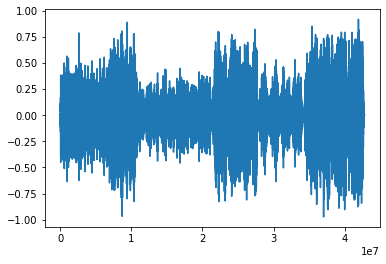

In [32]:
plt.figure()
plt.plot(waveform[0,:].numpy())

Shape of transformed waveform: torch.Size([1, 10690011])


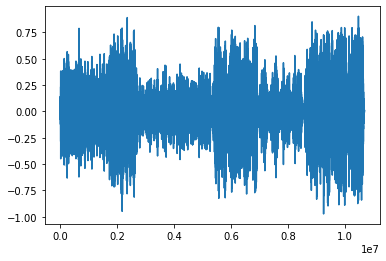

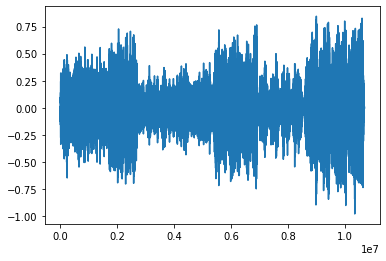

In [33]:
new_sample_rate = sample_rate/4

# Since Resample applies to a single channel, we resample first channel here
channel = 0
transformed0 = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(waveform[0,:].view(1,-1))
transformed1 = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(waveform[1,:].view(1,-1))

print("Shape of transformed waveform: {}".format(transformed0.size()))

plt.figure()
plt.plot(transformed0[0,:].numpy())
plt.figure()
plt.plot(transformed1[0,:].numpy())

In [34]:
out = torch.cat((transformed0, transformed1), 0)

In [35]:
torchaudio.save("/mnt/Data/maestro-v2.0.0/out.mp3", out, new_sample_rate, precision=16, channels_first=True)